In [71]:
#algorithm process:

# you will start with an imput tensor of size (batch,imputs)
# which will be batch number of xy pairs (a,b)
#this matrix will be transformed by the algorithm into a tensor of size (batch,classes) of raw logits
# which will be batch number of tuples [a,b,c,d] where a,b,c,d are the raw logits outputted by the model

# this will be fed into the CrossEntropyLoss() function, as well as the Y_test which is a tensor of size (batch,)
#where each element is the class that should be predicted

# this time, use cross entropy loss
#remember how BCELOSS was loss(y,p) = -(y*log(p)+(1-y)log(1-p))
#this way, p must be like y or else have a massive loss per prediction

#thus, into the CELoss we are feeding a tensor of probabilities [batch,num classes] which is actaully just the raw logits (no softmax)
#and the tensor of classes Y_test of form [1,2,0,3,0,2,1] where each value is the correct class 

#the formula for cross entropy loss is 

# L(for one sample) = (-)Sum from i=1 to C of (yi * log(pi))
#where C is the number of classes
#and yi is the boolean value 0 or 1 depending on if its the right class
#exe: if the right class is 3, then y1=0, y2=0, y3=1, y4=0, y5=0, ...
#and pi is the softmax(zi) where zi is the predicted logit that corresponds to the class

#exe cont:
#if the correct class is 3:
# formula simplicies to L = -log(p3)
# thus if p is close to 1, then loss is small, but if its close to 0 loss is huge

#also just use SDG for the optimizer


In [72]:
#ARGMAX: what it does:
#lets say you have torch.argmax(x,dim=1) where x is size (3,2,1)
#this means you want to flatten in dim=1. Thus, argmax will return a tensor of size (3,1) where there will be blocks of size 3, where 
# each block will be size 1 and a comparison in dim=1

#exe: if x is size (5,4,3,2,1)
#and you run a argmax(x,dim=2)
#it will return a tensor of size (5,4,2,1)
#were each block is an element in the (5,4) tensor
#and each block is of size 2,1 where each element is compared to the other elements in dim=1
# meaning the other 3 tensors of size (2,1)
# where it will replace each element with the index of the largest corresponding element.





In [73]:
#finally, lets begin coding using the sklearn make blobs method i think...
import torch 
from torch import nn

if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
else:
    device="cpu"

In [74]:
#now lets make the dataset
from sklearn.datasets import make_blobs

num_samples = 1000
num_features = 2
random_state = 42
num_classes = 4
num_hidden = 10

#X is shape (num_samples,num_features), Y is shape (num_samples) where each is the index of the shape
X,Y = make_blobs(n_samples=num_samples,n_features=num_features,shuffle=True,random_state=random_state,centers=num_classes)
X.shape,Y.shape #both numpy arrays


((1000, 2), (1000,))

In [75]:
#Lets insert the data into a dataframe for plotting
import pandas as pd

data = {
    "X-Value": X[:,0],
    "Y-Value": X[:,1],
    "Label": Y[:]
}
df = pd.DataFrame(data=data)

df.head(10)


,X-Value,Y-Value,Label
0,-8.555040,7.064618,3
1,-6.137532,-6.580817,2
2,-6.321300,-6.804104,2
3,4.180518,1.123325,1
4,4.380287,0.470027,1
5,-6.822614,-6.611517,2
6,5.020077,2.583755,1
7,-5.963300,-6.533621,2
8,-6.655713,-5.515969,2
9,5.846388,1.156234,1


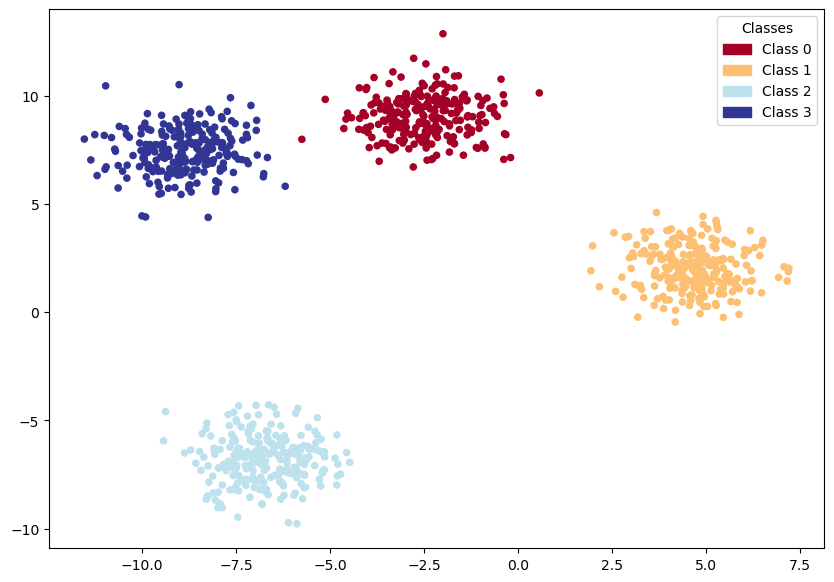

In [76]:
#Now, lets plot the data:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

plt.figure(figsize=(10,7))
plt.scatter(df["X-Value"],df["Y-Value"],s=20,c=df["Label"],cmap=plt.cm.RdYlBu)

classes = np.unique(df["Label"]) #returns a np array with only the unique elements sorted
cmap = plt.cm.RdYlBu

plot_elements = [
    mpatches.Patch(color=cmap((i - classes.min())/(classes.max() - classes.min())),label=f"Class {i}") #cmap maps numbers from 0 to 1 to colors
    #matplotlib normalizes the data using torch.normalize() which transforms the tensor so that all of its elements are between 0 and 1
    # using Vnorm = V - Vmin / Vmax - Vmin
    for i in classes
]

plt.legend(handles=plot_elements,title="Classes")
plt.show()


In [ ]:
#now, the train-test-split
from sklearn.model_selection import train_test_split

X_data,Y_labels = (torch.from_numpy(numarr).type(torch.float) for numarr in [X,Y])      

X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_labels,train_size=0.8,shuffle=True)

for obj in [X_train,X_test,Y_train,Y_test]:
    print(obj.shape,obj.dtype)

torch.Size([800, 2]) torch.float32
torch.Size([200, 2]) torch.float32
torch.Size([800]) torch.float32
torch.Size([200]) torch.float32


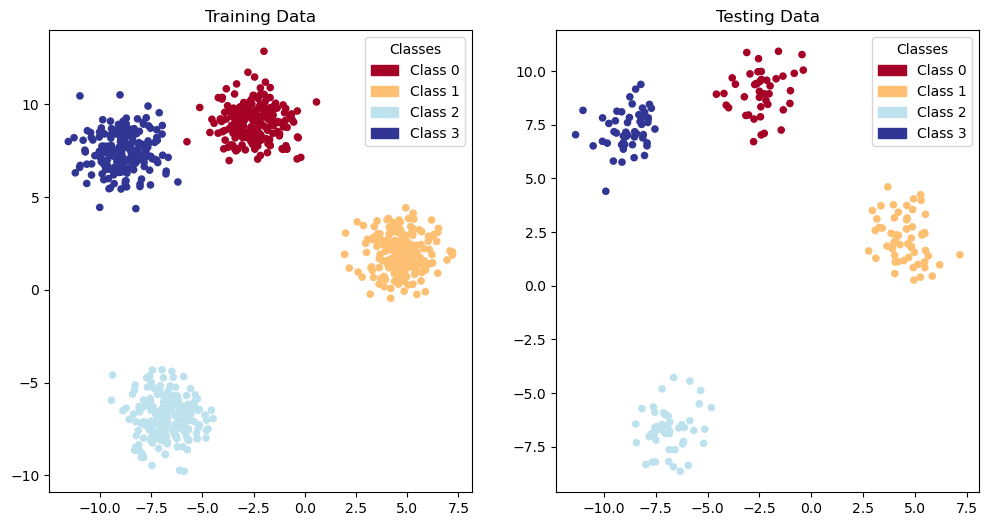

In [78]:
#lets plot the data (no point in using a df here lol)


classes = torch.unique(Y_test).type(torch.int32)
cmap=plt.cm.RdYlBu
plot_elements = [
    mpatches.Patch(color=cmap((i-classes.min())/(classes.max()-classes.min())),label=f"Class {i}")
    for i in classes
]


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0],X_train[:,1],s=20,c=Y_train,cmap=plt.cm.RdYlBu,label="Training Data")
plt.title("Training Data")
plt.legend(handles=plot_elements,title="Classes")

plt.subplot(1,2,2)
plt.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,cmap=plt.cm.RdYlBu,label="Testing Data")
plt.title("Testing Data")
plt.legend(handles=plot_elements,title="Classes")

In [79]:
#now that we got our data, lets build the model:



#ERRLOG: dont do self.seq = {}, because that creates a set literal, not a sequential object that wraps the layers you want
class MultiClassBlobModel(nn.Module):
    def __init__(self,num_classes,num_features,hidden_layers):
        super().__init__()
        self.sequential1 = nn.Sequential(
            nn.Linear(in_features=num_features,out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers,out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers,out_features=num_classes)
        )
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.sequential1(x)
    
model = MultiClassBlobModel(num_classes=num_classes,num_features=num_features,hidden_layers=num_hidden).to(device)

print(model.state_dict()) #if this just prints OrderedDict(), 

OrderedDict({'sequential1.0.weight': tensor([[ 0.6439, -0.4158],
        [-0.3287,  0.0593],
        [ 0.1396, -0.4908],
        [-0.0395,  0.2282],
        [ 0.2797, -0.6205],
        [-0.3207, -0.5949],
        [ 0.0251, -0.1924],
        [ 0.4438, -0.6912],
        [ 0.0581, -0.4604],
        [ 0.5583, -0.1454]], device='mps:0'), 'sequential1.0.bias': tensor([ 0.1165,  0.3101, -0.2158,  0.0503,  0.3667, -0.4308,  0.0554, -0.0276,
         0.2391, -0.5314], device='mps:0'), 'sequential1.2.weight': tensor([[-0.2907, -0.2416, -0.2587, -0.3005, -0.1467, -0.1167, -0.1827,  0.0814,
         -0.1413, -0.0027],
        [-0.0950,  0.1898,  0.0932,  0.2608,  0.0555,  0.2739, -0.2432, -0.1861,
          0.2983,  0.0134],
        [-0.1871, -0.1700,  0.2859,  0.3063,  0.0888,  0.2306,  0.1197,  0.1638,
          0.0732, -0.2826],
        [-0.1648,  0.0458,  0.1441, -0.3120, -0.1934,  0.1025, -0.1783, -0.1939,
          0.0496, -0.1455],
        [-0.2736,  0.2188, -0.2818, -0.2362, -0.2679, -0.01

In [80]:
#Now that our model is defined, we should define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [81]:
#now lets, do a deadshot of our model:
#first, lets move the data to the GPU:
X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in [X_train,X_test,Y_train,Y_test])


with torch.inference_mode():
    model.eval()
    #blind prediction
    y_blind_logit_preds = model(X_test) #size (batch,classes)
    y_blind_preds = (torch.softmax(y_blind_logit_preds,dim=0)).argmax(dim=1) #shoudl be size (batch,)
    print(f"The actual first few values are: {Y_test[:10]}")
    print(f"The predicted first few values are: {y_blind_preds[:10]}")


The actual first few values are: tensor([3., 2., 0., 2., 0., 2., 1., 1., 0., 3.], device='mps:0')
The predicted first few values are: tensor([1, 2, 1, 2, 1, 2, 3, 3, 1, 2], device='mps:0')


In [82]:
#lets see the plot_predictions for the model, no training:
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
    print("skip")
else:
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open(file="helper_functions.py",mode="wb",newline="") as file:
        file.write(request.content)

from helper_functions import plot_decision_boundary

skip


Text(0.5, 1.0, 'Testing Data')

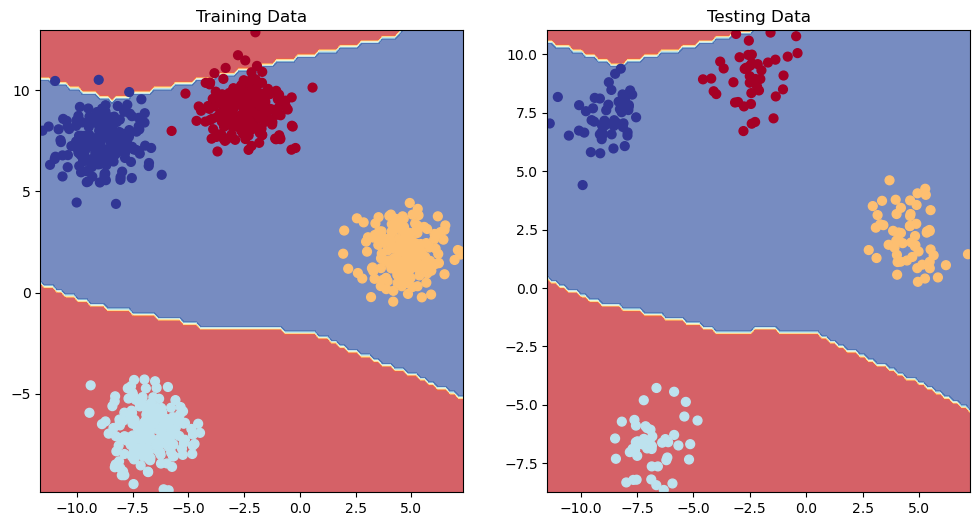

In [83]:
#now, lets see that descision boundary:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model,X_train,Y_train)
plt.title("Training Data")

plt.subplot(1,2,2)
plot_decision_boundary(model,X_test,Y_test)
plt.title("Testing Data")

In [86]:
#make an accuracy function that works directly on prediction logits:
def accuracy_fn(y_prediction_logits, ground_truth):
    y_predictions = torch.softmax(y_prediction_logits,dim=1).argmax(dim=1) #dim=1 means the sum down the rows must be 1 (which is correct)
    num_correct = torch.eq(y_predictions,ground_truth).sum().item()
    return (num_correct / ground_truth.numel())*100

with torch.inference_mode():
    model.eval()
    blind_acc = accuracy_fn(y_blind_logit_preds,Y_test)
    #ternary operator
    print(f"Current accuracy is: {blind_acc}, which is {"Booty" if blind_acc > 0.5 else "Pretty Good"}")

Current accuracy is: 26.5, which is Booty


In [89]:
#NOW we gotta get the paths configured :(
from pathlib import Path
from datetime import datetime

#consts:
MODEL_NAME = "UNIT2_MODEL2"
EXPERIMENT_NAME = "exp1"

now = datetime.now()
TIMESTAMP = f"{now.month}-{now.day}-{str(now.year)[-2:]}_@_{now.strftime("%I-%M-%S%p")}"
print(TIMESTAMP)

#now, lets get the directories in order:
BASE_DIR = Path(MODEL_NAME)
EXPERIMENT_DIR = BASE_DIR / EXPERIMENT_NAME

#now the other directories
MODEL_DIR = EXPERIMENT_DIR / "models"
RESULTS_DIR = EXPERIMENT_DIR / "results"
GRAPHS_DIR = EXPERIMENT_DIR / "graphs"
LOSS_GRAPH_DIR = GRAPHS_DIR / "loss"
ACC_GRAPH_DIR = GRAPHS_DIR / "accuracy"

#now, make them:

for directory in [MODEL_DIR,RESULTS_DIR,GRAPHS_DIR,LOSS_GRAPH_DIR,ACC_GRAPH_DIR]:
    directory.mkdir(parents=True,exist_ok=True)

#now, make the actual paths:
MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}"
RESULTS_PATH = RESULTS_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}"
LOSS_GRAPH_PATH = LOSS_GRAPH_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}"
ACC_GRAPH_PATH = ACC_GRAPH_DIR / f"{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}"

9-5-25_@_11-27-25AM


In [94]:
#NOW the training loop:
import csv
from torchmetrics.classification import Accuracy

epochs = 1000

model = model.to(device)
X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in [X_train,X_test,Y_train,Y_test])


with open(file=RESULTS_PATH,mode="w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch","Training Loss","Testing Loss","Training Accuracy","Testing Accuracy"])

    #create the accuracy objects:
    training_accuracy = Accuracy(task="multiclass",num_classes=num_classes).to(device)
    testing_accuracy = Accuracy(task="multiclass",num_classes=num_classes).to(device)

    #now start the training loop:
    for epoch in range(epochs):

        #forward pass the data
        model.train()
        Y_logit_preds = model(X_train)

        # reset the gradients:
        optimizer.zero_grad()

        #calculate the loss:
        loss = loss_fn(Y_logit_preds,Y_train)

        #backprop to find the gradients:
        loss.backward()

        #lastly, push the optimizer in the direction of the gradients:
        optimizer.step()

        #NOW, lets record the loss and accuracy every 10 epochs to make it run faster:

        if epoch % 10 == 0:

            #calculate the logits that are correct:
            Y_preds = torch.softmax(Y_logit_preds,dim=1).argmax(dim=1)
            training_accuracy.reset() #resets the old accuracy from the past batch.
            training_accuracy.update(Y_preds,Y_train)

            #start the testing loop:
            with torch.inference_mode():

                Y_test_logit_preds = model(X_test)
                Y_test_preds = torch.softmax(Y_test_logit_preds,dim=1).argmax(dim=1)

                #now find the testing accuracy
                testing_accuracy.reset()
                testing_accuracy.update(Y_test_preds,Y_test)

                #now calculate the testing loss:
                testing_loss = loss_fn(Y_test_logit_preds,Y_test)

                #Now, lets get ready to write to the csv:
                training_loss_write = loss.detach().cpu().numpy()
                testing_loss_write = testing_loss.detach().cpu().numpy()

                training_accuracy_write = training_accuracy.compute().item()
                testing_accuracy_write = testing_accuracy.compute().item()

                #now lets write them:
                writer.writerow([epoch,training_loss_write,testing_loss_write,training_accuracy_write,testing_accuracy_write])

                #lets print every 50 epochs to make our live easier:

                if epoch % 50 == 0:
                    print(f"Epoch: {epoch} | Training Loss: {training_loss_write} | Testing Loss: {testing_loss_write} | Training Accuracy: {training_accuracy_write} | Testing Accuracy: {testing_accuracy_write}")



Epoch: 0 | Training Loss: 1.2864757776260376 | Testing Loss: 1.2497977018356323 | Training Accuracy: 0.5037500262260437 | Testing Accuracy: 0.49000000953674316
Epoch: 50 | Training Loss: 0.267814040184021 | Testing Loss: 0.31573420763015747 | Training Accuracy: 0.987500011920929 | Testing Accuracy: 0.9750000238418579
Epoch: 100 | Training Loss: 0.13863471150398254 | Testing Loss: 0.1654224842786789 | Training Accuracy: 0.9975000023841858 | Testing Accuracy: 1.0
Epoch: 150 | Training Loss: 0.08852764219045639 | Testing Loss: 0.10545096546411514 | Training Accuracy: 0.9987499713897705 | Testing Accuracy: 1.0
Epoch: 200 | Training Loss: 0.0632922574877739 | Testing Loss: 0.07487750053405762 | Training Accuracy: 0.9987499713897705 | Testing Accuracy: 1.0
Epoch: 250 | Training Loss: 0.04868791997432709 | Testing Loss: 0.05708226189017296 | Training Accuracy: 0.9987499713897705 | Testing Accuracy: 1.0
Epoch: 300 | Training Loss: 0.039364129304885864 | Testing Loss: 0.04571182653307915 | Trai

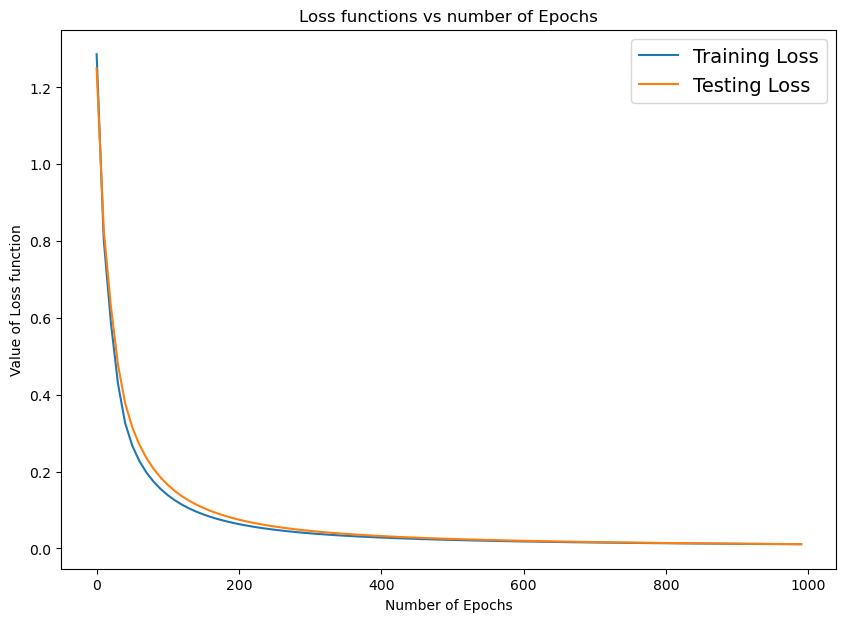

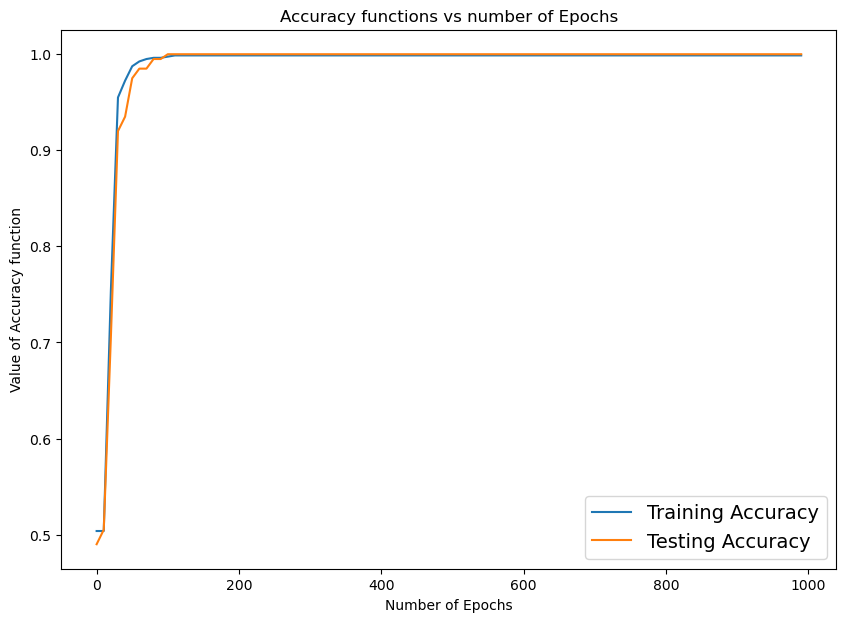

In [97]:
#now, lets make the graphs of the training and testing data

data = pd.read_csv(filepath_or_buffer=RESULTS_PATH)

plt.figure(figsize=(10,7))
plt.plot(data["Epoch"],data["Training Loss"],label="Training Loss")
plt.plot(data["Epoch"],data["Testing Loss"],label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Value of Loss function")
plt.title("Loss functions vs number of Epochs")
plt.legend(prop={"size":14})
plt.savefig(LOSS_GRAPH_PATH)
plt.show()
plt.close()

plt.figure(figsize=(10,7))
plt.plot(data["Epoch"],data["Training Accuracy"],label="Training Accuracy")
plt.plot(data["Epoch"],data["Testing Accuracy"],label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Value of Accuracy function")
plt.title("Accuracy functions vs number of Epochs")
plt.legend(prop={"size":14})
plt.savefig(ACC_GRAPH_PATH)
plt.show()
plt.close()




In [99]:
#now, lets run an inference on our model to see how well it plots its descision boundaries:

with torch.inference_mode():
    model.eval()
    y_infer_logit_preds = model(X_test)
    y_infer_preds = torch.softmax(y_infer_logit_preds,dim=1).argmax(dim=1)
    inferred_accuracy = accuracy_fn(y_prediction_logits=y_infer_logit_preds,ground_truth=Y_test)
    print(f"The actual classes of the first few objects is: {Y_test[:10]}")
    print(f"The predicted classes of the first few objects is: {y_infer_preds[:10]}")
    print(f"With an accuracy of {inferred_accuracy}, thats {"Booty" if inferred_accuracy < 0.95 else "Good"}")


The actual classes of the first few objects is: tensor([3., 2., 0., 2., 0., 2., 1., 1., 0., 3.], device='mps:0')
The predicted classes of the first few objects is: tensor([3, 2, 0, 2, 0, 2, 1, 1, 0, 3], device='mps:0')
With an accuracy of 100.0, thats Good


Text(0.5, 1.0, 'Testing Data')

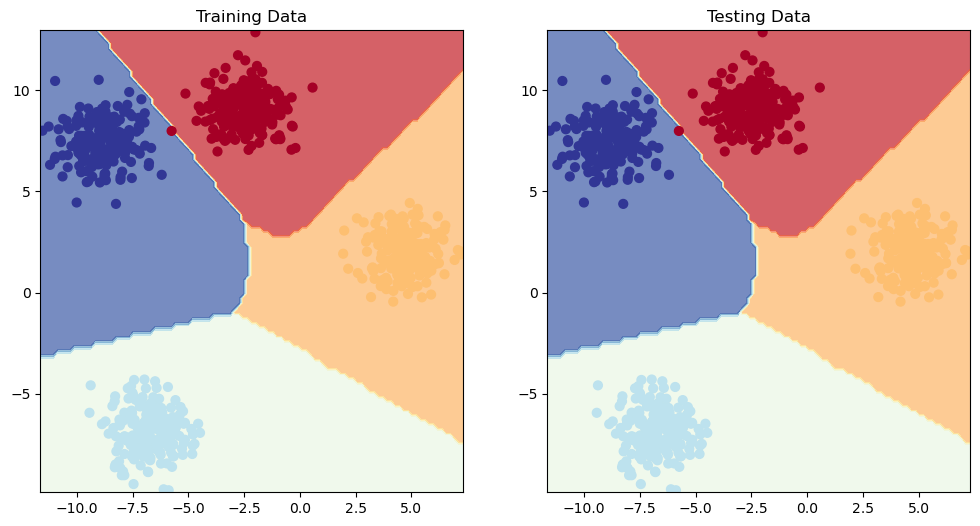

In [100]:
#now, lets actually see these descision boundaries:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model,X_train,Y_train)
plt.title("Training Data")

plt.subplot(1,2,2)
plot_decision_boundary(model,X_train,Y_train)
plt.title("Testing Data")

In [101]:
#now lets save the model:
torch.save(obj=model.state_dict(),f=MODEL_PATH)

In [102]:
#now, lets load the model;

model_loaded = MultiClassBlobModel(num_classes=num_classes,num_features=num_features,hidden_layers=num_hidden)
model_loaded.load_state_dict(torch.load(f=MODEL_PATH,weights_only=True))

<All keys matched successfully>

Text(0.5, 1.0, 'Testing Data')

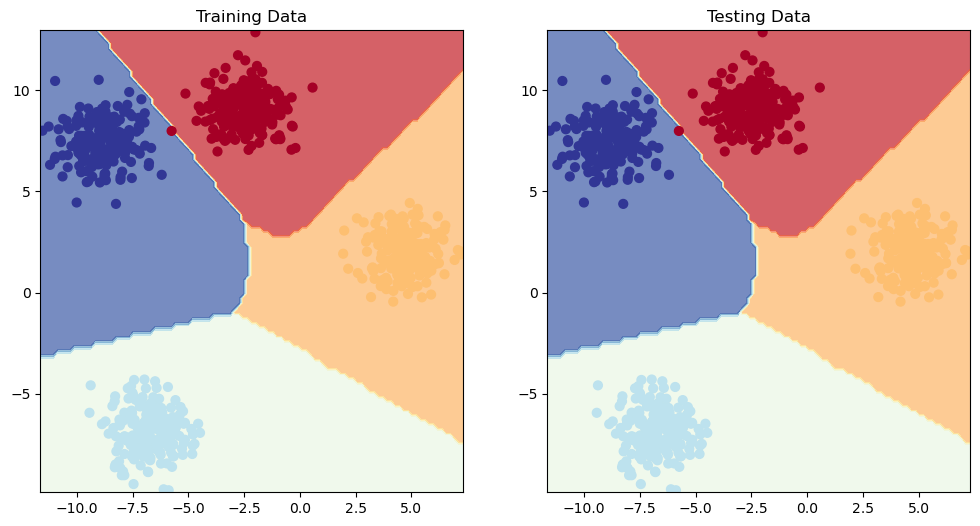

In [103]:
#now, lets see that preformance again on our model:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_loaded,X_train,Y_train)
plt.title("Training Data")

plt.subplot(1,2,2)
plot_decision_boundary(model_loaded,X_train,Y_train)
plt.title("Testing Data")
